# Домашнее задание № 5.
## Прогнозирование временных рядов с помощью рекуррентной нейронной сети (RNN)


- Датасет "data_example.csv" (Практика 2.1)
- Информация о данных "02_Итоговое задание.pdf" (Практика 2.1)

### Задачи

Сделайте обработку данных (см. Практика 2.1) и для одной из холодильных горок реализуйте следующие модели RNN:

1. Для одномерного и многомерного прогнозирования напишите функции для скользящего окна.
2. Одномерное одношаговое прогнозирование температуры воздуха на входе в испаритель и внутри установки.
3. Многомерное одношаговое прогнозирование температуры воздуха на входе в испаритель и внутри установки (с одним выходом и с двумя выходами).
4. Одномерное многошаговое (несколько минут и часов) прогнозирование температуры воздуха на входе в испаритель и внутри установки.
5. Многомерное многошаговое (несколько минут и часов) прогнозирование температуры воздуха на входе в испаритель и внутри установки (с одним выходом и с двумя выходами).


* Для каждой модели вычислите метрики качества.
* Какая модель делает предсказания лучше: стат.модель ARIMA или RNN?.

Для пунктов 2-5 нужно определить гиперпараметры, подобрать оптимальное количество слоев НС.
Определить количество эпох обучения (из графика кривой обучения).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Загрузка данных
data = pd.read_csv("data_example.csv",
                   sep=",",
                   header=[0,1,2,3],
                   skiprows=1,
                   na_values=['Missing','nan','Offln'],
                   encoding_errors='ignore')

Предобработка данных

In [3]:
data.columns = data.columns.droplevel([1,2,3])
data = data.rename(columns={'Name':'time'})


In [4]:
data['time'] = pd.to_datetime(data['time'], format=' %H:%M:%S %d/%m/%Y')
data.index = data.pop('time')
data = data.sort_index()


In [5]:
data = data.ffill().bfill()
print("Пропущенные значения после обработки:")
print(data.isnull().sum())

Пропущенные значения после обработки:
10CT G PBP -1/+1:   --- EKC состояние    0
10CT G PBP -1/+1:   u09 S5 Темп          0
11CT G OVZ +5/+8:   u69 Sair Темп        0
11CT G OVZ +5/+8:   u09 S5 Темп          0
11CT G OVZ +5/+8:   --- EKC состояние    0
                                        ..
111CT AG:   Cond Requested Cap           0
111CT AG:   Cond Running Cap             0
111CT AG:   Cond Ctrl Pressure           0
111CT AG:   Sc3 Датч нар воздуха         0
111CT AG:   Cond Reference               0
Length: 95, dtype: int64


Нормализация данных и подготовка наборов

In [6]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[['25CT V GSR +2/+4:   u09 S5 Темп', '25CT V GSR +2/+4:   u69 Sair Темп']])

In [8]:
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]


In [9]:
def create_univariate_dataset(data, window_size=24, horizon=1):
    X, y = [], []
    for i in range(len(data)-window_size-horizon+1):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size:i+window_size+horizon])
    return np.array(X), np.array(y)

def create_multivariate_dataset(data, window_size=24, horizon=1):
    X, y = [], []
    for i in range(len(data)-window_size-horizon+1):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size:i+window_size+horizon, 0])  # Прогнозируем только первый признак
    return np.array(X), np.array(y)

In [11]:
X_uni_train, y_uni_train = create_univariate_dataset(train_data[:, 0])
X_uni_test, y_uni_test = create_univariate_dataset(test_data[:, 0])

X_multi_train, y_multi_train = create_multivariate_dataset(train_data)
X_multi_test, y_multi_test = create_multivariate_dataset(test_data)

Univariate LSTM модель

In [12]:
uni_model = Sequential([
    LSTM(64, activation='relu', input_shape=(24, 1)),
    Dense(1)
])
uni_model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=5)
uni_history = uni_model.fit(
    X_uni_train, y_uni_train,
    epochs=50,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=0
)

Multivariate LSTM модель

In [13]:
multi_model = Sequential([
    LSTM(64, activation='relu', input_shape=(24, 2)),
    Dense(1)
])
multi_model.compile(optimizer='adam', loss='mse')

multi_history = multi_model.fit(
    X_multi_train, y_multi_train,
    epochs=50,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=0
)

#ARIMA модель

Подготовка данных для ARIMA

In [14]:
train_arima = train_data[:, 0]
test_arima = test_data[:, 0]

arima_model = ARIMA(train_arima, order=(5,1,0))
arima_fit = arima_model.fit()
arima_pred = arima_fit.forecast(steps=len(test_arima))


### Прогнозирование и оценка моделей

In [15]:
uni_pred = uni_model.predict(X_uni_test)
multi_pred = multi_model.predict(X_multi_test)

163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [16]:
metrics = {
    'Univariate LSTM': {
        'MAE': mean_absolute_error(y_uni_test, uni_pred),
        'RMSE': np.sqrt(mean_squared_error(y_uni_test, uni_pred))
    },
    'Multivariate LSTM': {
        'MAE': mean_absolute_error(y_multi_test, multi_pred),
        'RMSE': np.sqrt(mean_squared_error(y_multi_test, multi_pred))
    },
    'ARIMA': {
        'MAE': mean_absolute_error(test_arima, arima_pred),
        'RMSE': np.sqrt(mean_squared_error(test_arima, arima_pred))
    }
}


График метрик

(array([0, 1, 2]),
 [Text(0, 0, 'Univariate LSTM'),
  Text(1, 0, 'Multivariate LSTM'),
  Text(2, 0, 'ARIMA')])

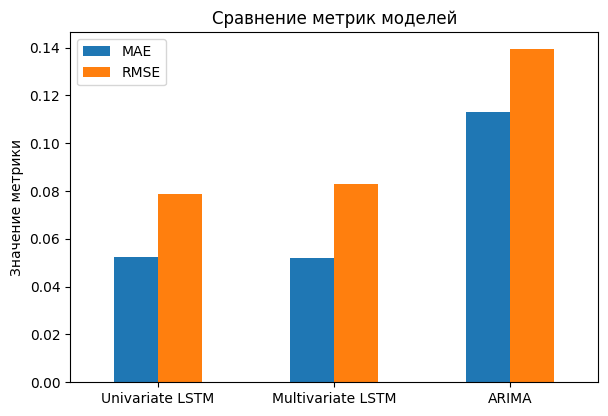

In [18]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
metrics_df = pd.DataFrame(metrics).T
metrics_df.plot(kind='bar', ax=plt.gca())
plt.title('Сравнение метрик моделей')
plt.ylabel('Значение метрики')
plt.xticks(rotation=0)


График потерь при обучении

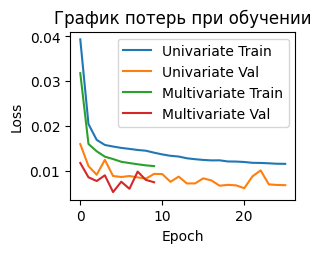

In [19]:
plt.subplot(2, 2, 2)
plt.plot(uni_history.history['loss'], label='Univariate Train')
plt.plot(uni_history.history['val_loss'], label='Univariate Val')
plt.plot(multi_history.history['loss'], label='Multivariate Train')
plt.plot(multi_history.history['val_loss'], label='Multivariate Val')
plt.title('График потерь при обучении')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()


График прогнозов

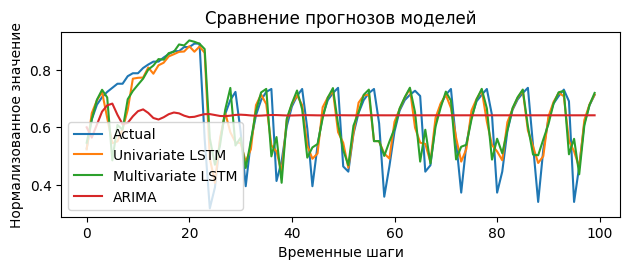

In [20]:
plt.subplot(2, 1, 2)
plt.plot(y_uni_test[:100], label='Actual')
plt.plot(uni_pred[:100], label='Univariate LSTM')
plt.plot(multi_pred[:100], label='Multivariate LSTM')
plt.plot(arima_pred[:100], label='ARIMA')
plt.title('Сравнение прогнозов моделей')
plt.ylabel('Нормализованное значение')
plt.xlabel('Временные шаги')
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
print("Метрики качества моделей:")
print(pd.DataFrame(metrics))

Метрики качества моделей:
      Univariate LSTM  Multivariate LSTM     ARIMA
MAE          0.052186           0.051806  0.113118
RMSE         0.078866           0.083042  0.139396
